In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn 
from torch.nn import functional as F

import utils
%matplotlib inline

### Weight Decay

Generate Data:

$$
y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }\epsilon \sim \mathcal{N}(0, 0.01^2)
$$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
w_true, b_true = torch.ones((num_inputs,)) * 0.01, 0.05

train_x, train_y = utils.generate_data(w_true, b_true, n_train)
test_x, test_y = utils.generate_data(w_true, b_true, n_test)

train_iter = utils.load_array((train_x, train_y), batch_size)
test_iter = utils.load_array((test_x, test_y), batch_size)

In [3]:
epochs = 25
lr = 0.01

def train(model, loss, optimizer, train_iter, test_iter, epochs):
    train_rec = utils.EpochRecorder(2)
    test_rec = utils.EpochRecorder(2)
    train_metric = utils.Accumulator(3)
    test_metric = utils.Accumulator(3)
    for epoch in range(epochs):
        train_metric.reset()
        test_metric.reset()
        
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(model(X).reshape(y.shape), y)
            l.backward()
            optimizer.step()
            train_metric.add(float(l), float(torch.norm(model.weight[0].detach())), y.numel())
        train_rec.append(train_metric[0] / train_metric[2], train_metric[1])
        
        with torch.no_grad():
            for X,y in test_iter:
                l = loss(model(X).reshape(y.shape), y)
                test_metric.add(float(l), float(torch.norm(model.weight[0].detach())), y.numel())
            test_rec.append(train_metric[0] / train_metric[2], train_metric[1])
        
        print('epoch: {}, train loss: {:.3f}, train norm: {:.3f}, test loss: {:.3f}, test norm: {:.3f}'.format(
            epoch, 
            train_rec.get_num(0), train_rec.get_num(1),
            test_rec.get_num(0), test_rec.get_num(1),
        ))
    return train_rec, test_rec


In [4]:
model1 = nn.Linear(num_inputs, 1)
model2 = nn.Linear(num_inputs, 1)
model2.load_state_dict(model1.state_dict())

<All keys matched successfully>

In [5]:
loss1 = nn.MSELoss()
opt1 = torch.optim.SGD(model1.parameters(), lr)
train_rec1, test_rec1 = train(model1, loss1, opt1, train_iter, test_iter, epochs)


epoch: 0, train loss: 0.043, train norm: 2.152, test loss: 0.043, test norm: 2.152
epoch: 1, train loss: 0.024, train norm: 2.137, test loss: 0.024, test norm: 2.137
epoch: 2, train loss: 0.017, train norm: 2.131, test loss: 0.017, test norm: 2.131
epoch: 3, train loss: 0.013, train norm: 2.128, test loss: 0.013, test norm: 2.128
epoch: 4, train loss: 0.010, train norm: 2.126, test loss: 0.010, test norm: 2.126
epoch: 5, train loss: 0.008, train norm: 2.125, test loss: 0.008, test norm: 2.125
epoch: 6, train loss: 0.007, train norm: 2.125, test loss: 0.007, test norm: 2.125
epoch: 7, train loss: 0.006, train norm: 2.124, test loss: 0.006, test norm: 2.124
epoch: 8, train loss: 0.006, train norm: 2.124, test loss: 0.006, test norm: 2.124
epoch: 9, train loss: 0.005, train norm: 2.123, test loss: 0.005, test norm: 2.123
epoch: 10, train loss: 0.005, train norm: 2.123, test loss: 0.005, test norm: 2.123
epoch: 11, train loss: 0.004, train norm: 2.123, test loss: 0.004, test norm: 2.123
ep

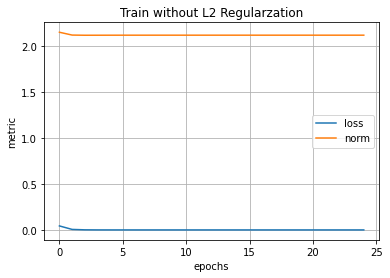

In [6]:
train_rec1.plot(labels=('loss', 'norm'), title='Train without L2 Regularzation')

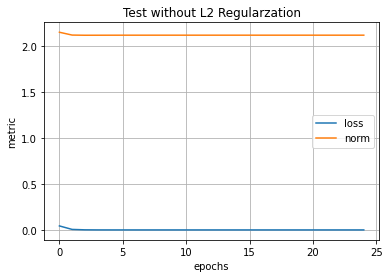

In [7]:
test_rec1.plot(labels=('loss', 'norm'), title='Test without L2 Regularzation')

In [8]:
def loss_L2(y_hat, y):
    loss = nn.MSELoss()
    return loss(y_hat, y) + 0.5 * torch.norm(model2.weight[0])**2

loss2 = loss_L2
opt2 = torch.optim.SGD(model2.parameters(), lr)
train_rec2, test_rec2 = train(model2, loss2, opt2, train_iter, test_iter, epochs)

epoch: 0, train loss: 0.071, train norm: 2.099, test loss: 0.071, test norm: 2.099
epoch: 1, train loss: 0.050, train norm: 2.043, test loss: 0.050, test norm: 2.043
epoch: 2, train loss: 0.042, train norm: 1.999, test loss: 0.042, test norm: 1.999
epoch: 3, train loss: 0.037, train norm: 1.958, test loss: 0.037, test norm: 1.958
epoch: 4, train loss: 0.033, train norm: 1.919, test loss: 0.033, test norm: 1.919
epoch: 5, train loss: 0.031, train norm: 1.881, test loss: 0.031, test norm: 1.881
epoch: 6, train loss: 0.029, train norm: 1.845, test loss: 0.029, test norm: 1.845
epoch: 7, train loss: 0.027, train norm: 1.811, test loss: 0.027, test norm: 1.811
epoch: 8, train loss: 0.026, train norm: 1.777, test loss: 0.026, test norm: 1.777
epoch: 9, train loss: 0.025, train norm: 1.744, test loss: 0.025, test norm: 1.744
epoch: 10, train loss: 0.023, train norm: 1.712, test loss: 0.023, test norm: 1.712
epoch: 11, train loss: 0.022, train norm: 1.681, test loss: 0.022, test norm: 1.681
ep

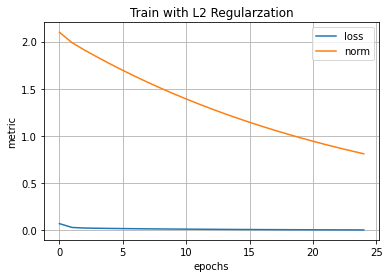

In [9]:
train_rec2.plot(labels=('loss', 'norm'), title='Train with L2 Regularzation')

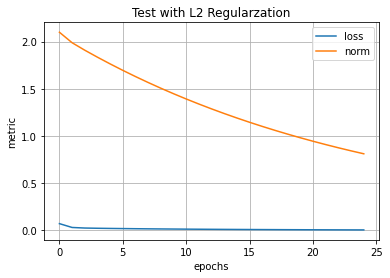

In [10]:
test_rec2.plot(labels=('loss', 'norm'), title='Test with L2 Regularzation')

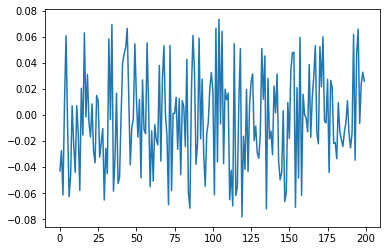

In [11]:
plt.plot(model1.weight[0].detach())

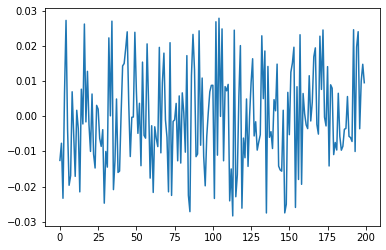

In [12]:
plt.plot(model2.weight[0].detach())

### Dropout

Implemention from Scratch:

In [21]:
def dropout(X, p):
    assert 0 <= p <= 1
    if p == 1:
        return X
    elif p == 0:
        return torch.zeros_like(X)
    else:
        mask = (torch.rand(X.shape) > p).float()
        return X * mask / (1 - p)

In [22]:
X = torch.randn((3, 4))
print(X)
dropout(X, 0.5)

tensor([[-0.0943, -0.1611,  0.2760, -0.1855],
        [ 0.4222,  1.0164, -0.9151, -0.1953],
        [ 1.2795,  0.9806, -1.2394,  0.8360]])


tensor([[-0.0000, -0.3222,  0.0000, -0.3710],
        [ 0.8444,  0.0000, -0.0000, -0.0000],
        [ 0.0000,  1.9612, -0.0000,  0.0000]])

Concise:

In [26]:
net = nn.Sequential(
    nn.Linear(12, 32), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32, 1)
)

net.state_dict()

OrderedDict([('0.weight',
              tensor([[-1.5584e-01, -7.5270e-02, -2.2717e-01, -1.3765e-04,  3.8626e-02,
                        2.1342e-01,  7.5973e-02,  1.4843e-01,  2.6919e-01, -1.5861e-02,
                        9.0442e-02,  4.0917e-02],
                      [ 9.1846e-02,  2.0005e-01, -1.6777e-01, -7.9838e-02,  2.6479e-01,
                       -6.5753e-02,  2.8220e-01,  1.0561e-01,  2.8248e-02,  4.6087e-02,
                       -2.7524e-02,  2.2504e-01],
                      [-6.7281e-02, -4.0152e-02, -2.4539e-01,  2.5963e-02,  2.6216e-01,
                        3.5606e-02, -2.0577e-01, -1.7739e-01,  1.6053e-01,  6.8000e-02,
                        1.5646e-01, -2.0889e-01],
                      [ 2.8231e-01,  1.4114e-01, -4.0085e-02, -2.2134e-01,  2.4652e-01,
                        7.1880e-03, -7.6480e-02, -2.1164e-02, -1.7435e-01, -1.6862e-01,
                       -4.1652e-02,  1.4536e-01],
                      [-2.2859e-01, -5.4854e-02, -2.7677e-01,  2.8694e